# Install requirements

In [7]:
# Install requirements
!pip install fastapi==0.68.1
!pip install opencv-python==4.5.3.56
# !pip install Pillow==8.3.2
!pip install timm==0.4.12
!pip install python-multipart==0.0.5
!pip install uvicorn==0.15.0

  Using cached opencv-python-4.5.3.56.tar.gz (89.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [8]:
!pip install nest-asyncio

In [9]:
!pip install pyngrok

In [10]:
from typing import List

from fastapi import FastAPI, File, UploadFile
from fastapi.responses import HTMLResponse, StreamingResponse

import cv2
import io
import numpy as np

import torch
import cv2
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

## DPT Model

In [11]:
def load_model_dpt(model_type):
  ## Load model

  # MiDaS v3 - Large
  # (highest accuracy, slowest inference speed)
  # model_type = "DPT_Large"

  # MiDaS v3 - Hybrid
  # (medium accuracy, medium inference speed)
  # model_type = "DPT_Hybrid"

  # (lowest accuracy, highest inference speed)
  # model_type = "MiDaS_small"  # MiDaS v2.1 - Small

  midas = torch.hub.load("intel-isl/MiDaS", model_type)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  midas.to(device)
  midas.eval()

  return midas


def pre_process_dpt(image, model_type):

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transfor

    # Load image
    img = cv2.imdecode(np.frombuffer(image.file.read(),
                                      np.uint8),
                        cv2.IMREAD_COLOR)

    # convert it to the correct format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Transform it so that it can be used by the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = transform(img).to(device)

    # Return this image so it can be used in postprocessing
    return input_batch, img

def post_process_dpt(original, prediction):

  prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=original.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()

  output = prediction.cpu().numpy()
  # Create a figure using matplotlib which super-imposes the original
  # image and the prediction

  fig = Figure()
  canvas = FigureCanvas(fig)
  ax = fig.gca()

  # Render both images original as foreground
  ax.imshow(original)
  ax.imshow(output)

  ax.axis("off")
  canvas.draw()

  # Reshape output to be a numpy array
  width, height = fig.get_size_inches() * fig.get_dpi()
  width = int(width)
  height = int(height)
  output_image = np.frombuffer(canvas.tostring_rgb(),
                                dtype='uint8').reshape(height, width, 3)

  # Encode to png
  res, im_png = cv2.imencode(".png", output_image)

  return im_png



# Setup the server

In [12]:
!git clone https://github.com/InterDigitalInc/HRFAE.git
%cd HRFAE

Cloning into 'HRFAE'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 2.79 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/HRFAE


In [13]:
%cd logs/001
!./download.sh
%cd ./../..

/content/HRFAE/logs/001
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49.2M  100 49.2M    0     0   566k      0  0:01:28  0:01:28 --:--:--  595k
/content/HRFAE


In [14]:
import argparse
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import yaml

import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from torchvision import transforms, utils

from datasets import *
from nets import *
from functions import *
from trainer import *

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', type=str, default='001', help='path to the config file.')
parser.add_argument('--vgg_model_path', type=str, default='./models/dex_imdb_wiki.caffemodel.pt', help='pretrained age classifier')
parser.add_argument('--log_path', type=str, default='./logs/', help='log file path')
parser.add_argument('--multigpu', type=bool, default=False, help='use multiple gpus')
parser.add_argument('--checkpoint', type=str, default='', help='checkpoint file path')
parser.add_argument('--img_path', type=str, default='./test/input/', help='test image path')
parser.add_argument('--out_path', type=str, default='./test/output/', help='test output path')
parser.add_argument('--target_age', type=int, default=55, help='Age transform target, interger value between 20 and 70')
opts = parser.parse_known_args()[0]

log_dir = os.path.join(opts.log_path, opts.config) + '/'
if not os.path.exists(opts.out_path):
    os.makedirs(opts.out_path)

config = yaml.safe_load(open('./configs/' + opts.config + '.yaml', 'r'))
img_size = (config['input_w'], config['input_h'])

# Initialize trainer
trainer = Trainer(config)
device = torch.device('cuda')
trainer.to(device)

# Load pretrained model
if opts.checkpoint:
    trainer.load_checkpoint(opts.checkpoint)
else:
    trainer.load_checkpoint(log_dir + 'checkpoint')

def preprocess(img_name):
    resize = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
            ])
    normalize = transforms.Normalize(mean=[0.48501961, 0.45795686, 0.40760392], std=[1,1,1])
    img_pil = Image.open(opts.img_path + img_name)
    img_np = np.array(img_pil)
    img = resize(img_pil)
    if img.size(0) == 1:
        img = torch.cat((img, img, img), dim = 0)
    img = normalize(img)
    return img

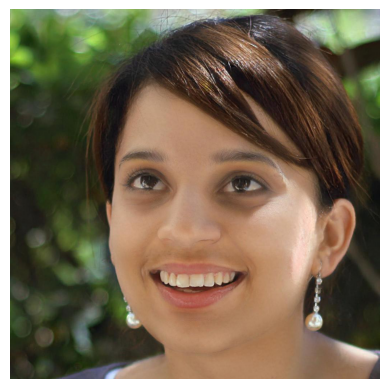

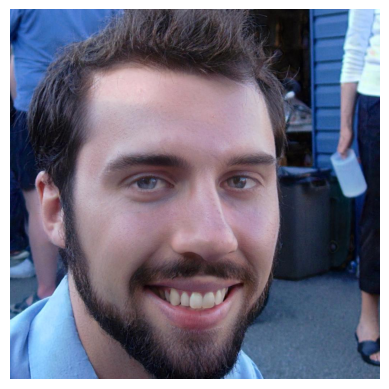

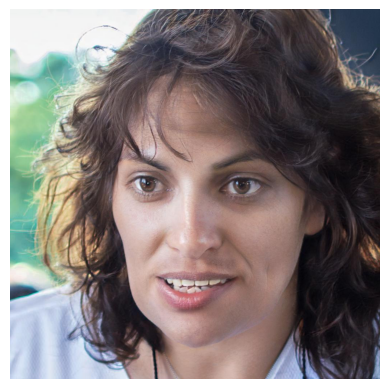

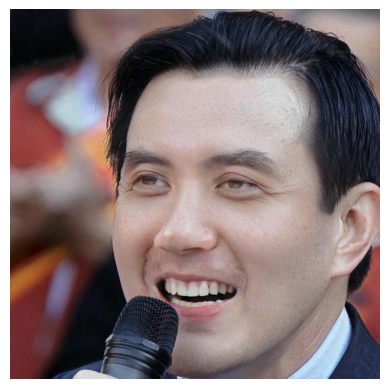

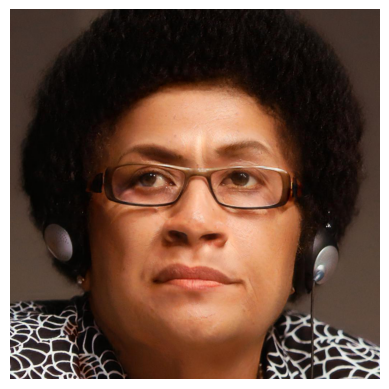

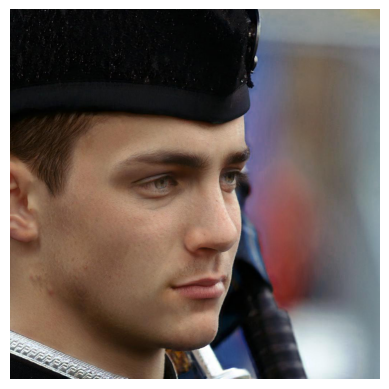

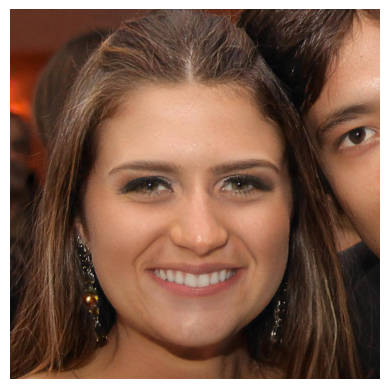

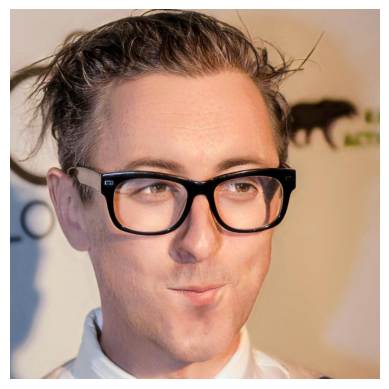

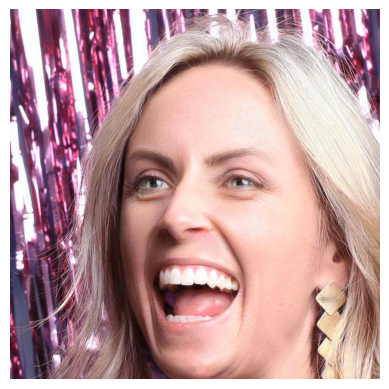

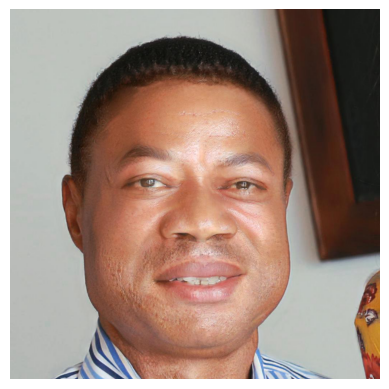

In [16]:
# Set target age
target_age = 28

# Load test image
img_list = os.listdir(opts.img_path)
img_list.sort()

with torch.no_grad():
    for img_name in img_list:
        if not img_name.endswith(('png', 'jpg', 'PNG', 'JPG')):
            print('File ignored: ' + img_name)
            continue
        image_A = preprocess(img_name)
        image_A = image_A.unsqueeze(0).to(device)

        age_modif = torch.tensor(target_age).unsqueeze(0).to(device)
        image_A_modif = trainer.test_eval(image_A, age_modif, target_age=target_age, hist_trans=True)
        utils.save_image(clip_img(image_A_modif), opts.out_path + img_name.split('.')[0] + '_age_' + str(target_age) + '.jpg')

        # Plot manipulated image
        img_out = np.array(Image.open(opts.out_path + img_name.split('.')[0] + '_age_' + str(target_age) + '.jpg'))
        plt.axis('off')
        plt.imshow(img_out)
        plt.show()

In [17]:
# Code from: https://fastapi.tiangolo.com/tutorial/request-files/
app = FastAPI()


@app.post("/uploadfiles/")
async def create_upload_files(files: List[UploadFile] = File(...)):
    """ Create API endpoint to send image to and specify
     what type of file it'll take

    :param files: Get image files, defaults to File(...)
    :type files: List[UploadFile], optional
    :return: A list of png images
    :rtype: list(bytes)
    """


    with torch.no_grad():
        for img_name in files:
            if not img_name.endswith(('png', 'jpg', 'PNG', 'JPG')):
                print('File ignored: ' + img_name)
                continue
            image_A = preprocess(img_name)
            image_A = image_A.unsqueeze(0).to(device)

            age_modif = torch.tensor(target_age).unsqueeze(0).to(device)
            image_A_modif = trainer.test_eval(image_A, age_modif, target_age=target_age, hist_trans=True)
            utils.save_image(clip_img(image_A_modif), opts.out_path + img_name.split('.')[0] + '_age_' + str(target_age) + '.jpg')

            # Plot manipulated image
            img_out = np.array(Image.open(opts.out_path + img_name.split('.')[0] + '_age_' + str(target_age) + '.jpg'))
            plt.axis('off')
            plt.imshow(img_out)
            plt.show()

        return StreamingResponse(io.BytesIO(img_out.tobytes()),
                              media_type="image/png")


@app.get("/")
async def main():
    """Create a basic home page to upload a file

    :return: HTML for homepage
    :rtype: HTMLResponse
    """

    content = """<body>
          <h3>Upload an image to get it's depth map from the MiDaS model</h3>
          <form action="/uploadfiles/" enctype="multipart/form-data" method="post">
              <input name="files" type="file" multiple>
              <input type="submit">
          </form>
      </body>
      """
    return HTMLResponse(content=content)


In [18]:
auth_token = "" #@param {type:"string"}
# Since we can't access Colab notebooks IP directly we'll use
# ngrok to create a public URL for the server via a tunnel

# Authenticate ngrok
# https://dashboard.ngrok.com/signup
# Then go to the "Your Authtoken" tab in the sidebar and copy the API key
import os
os.system(f"ngrok authtoken {auth_token}")

0

In [ ]:
!pip install pyngrok --upgrade

In [25]:

from pyngrok import ngrok

# Create tunnel
public_url = ngrok.connect(bind_tls=True)

In [26]:
# Check if it exists
!ps aux | grep ngrok

root        9817  0.2  0.2 736448 26832 ?        Sl   10:31   0:01 /usr/local/lib/python3.10/dist-packages/pyngrok/bin/ngrok start --none --log=stdout
root       12310  0.0  0.0   6904  3396 ?        S    10:41   0:00 /bin/bash -c ps aux | grep ngrok
root       12312  0.0  0.0   6444   648 ?        S    10:41   0:00 grep ngrok


# Make magic happen

In [ ]:
import nest_asyncio

# Allow for asyncio to work within the Jupyter notebook cell
nest_asyncio.apply()

import uvicorn

# Run the FastAPI app using uvicorn
print(public_url)
uvicorn.run(app)

INFO:     Started server process [377]
INFO:uvicorn.error:Started server process [377]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


NgrokTunnel: "https://af1e-34-68-26-207.ngrok.io" -> "http://localhost:80"


In [ ]:
# Kill tunnel
ngrok.disconnect(public_url=public_url)